# 9 Recommendation Systems
http://infolab.stanford.edu/~ullman/mmds/ch9.pdf
## 9.3 Collaborative Filtering (p321-327)
### 9.3.4 Exercises for Section 9.3 (p326)

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns

DEFAULT_HEATMAP_KWARGS = {
    "square": True,
    "annot": True,
    "cmap": "RdBu",
    "cbar": False,
    "vmin": 0, 
    "vmax": 1
}

In [2]:
df = pd.DataFrame(
    [[4, 5, None, 5, 1, None, 3, 2],[None, 3, 4, 3, 1, 2, 1, None], [2, None, 1, 3, None, 4, 5, 3]],
    index=list("ABC"),
    columns=list("abcdefgh")
)
df

,a,b,c,d,e,f,g,h
A,4.0,5.0,NaN,5,1.0,NaN,3,2.0
B,NaN,3.0,4.0,3,1.0,2.0,1,NaN
C,2.0,NaN,1.0,3,NaN,4.0,5,3.0


**Exercise 9.3.1** : Figure 9.8 is a utility matrix, representing the ratings, on a
1–5 star scale, of eight items, a through h, by three users A, B, and C. Compute
the following from the data of this matrix.

- (a) Treating the utility matrix as boolean, compute the Jaccard distance between each pair of users.

In [3]:
bool_utility_matrix = df.notna().astype(int)
bool_utility_matrix

,a,b,c,d,e,f,g,h
A,1,1,0,1,1,0,1,1
B,0,1,1,1,1,1,1,0
C,1,0,1,1,0,1,1,1


In [4]:
# solution
1 - pairwise_distances(bool_utility_matrix, metric="hamming")

array([[1. , 0.5, 0.5],
       [0.5, 1. , 0.5],
       [0.5, 0.5, 1. ]])

In [5]:
# my implementation
def jaccard_distance(utilities):
    intersection = utilities @ utilities.T + (1 - utilities) @ (1 - utilities.T)
    union = utilities.shape[1]
    return intersection / union

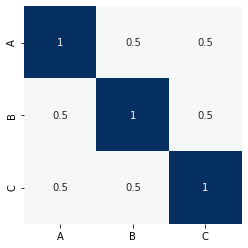

In [6]:
sns.heatmap(jaccard_distance(bool_utility_matrix), **DEFAULT_HEATMAP_KWARGS)

- (b) Repeat Part (a), but use the cosine distance.

In [7]:
fillzero_utility_matrix = df.fillna(0)
fillzero_utility_matrix

,a,b,c,d,e,f,g,h
A,4.0,5.0,0.0,5,1.0,0.0,3,2.0
B,0.0,3.0,4.0,3,1.0,2.0,1,0.0
C,2.0,0.0,1.0,3,0.0,4.0,5,3.0


In [8]:
# solution
1 - pairwise_distances(fillzero_utility_matrix, metric="cosine")

array([[1.        , 0.60104076, 0.61491869],
       [0.60104076, 1.        , 0.51387012],
       [0.61491869, 0.51387012, 1.        ]])

In [9]:
# my implementation
def cosine_distance(utilities):
    scalar_product = utilities @ utilities.T
    norm = utilities.apply(np.linalg.norm, axis="columns").to_frame()
    return scalar_product / (norm @ norm.T)

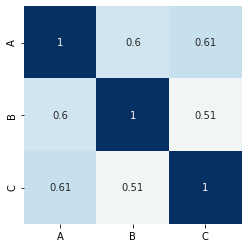

In [10]:
sns.heatmap(cosine_distance(fillzero_utility_matrix), **DEFAULT_HEATMAP_KWARGS)

- (c) Treat ratings of 3, 4, and 5 as 1 and 1, 2, and blank as 0. Compute the
Jaccard distance between each pair of users.

In [11]:
rounding_utility_matrix = (df >= 3).astype(int)
rounding_utility_matrix

,a,b,c,d,e,f,g,h
A,1,1,0,1,0,0,1,0
B,0,1,1,1,0,0,0,0
C,0,0,0,1,0,1,1,1


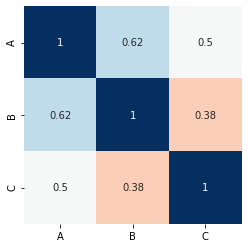

In [12]:
sns.heatmap(jaccard_distance(rounding_utility_matrix), **DEFAULT_HEATMAP_KWARGS)

- (d) Repeat Part (c), but use the cosine distance.

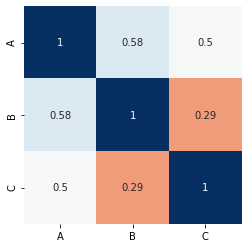

In [13]:
sns.heatmap(cosine_distance(rounding_utility_matrix), **DEFAULT_HEATMAP_KWARGS)

- (e) Normalize the matrix by subtracting from each nonblank entry the average
value for its user.

In [14]:
normalised_utility_matrix = df.sub(df.mean(axis="columns"), axis="index").fillna(0)
normalised_utility_matrix

,a,b,c,d,e,f,g,h
A,0.666667,1.666667,0.000000,1.666667,-2.333333,0.000000,-0.333333,-1.333333
B,0.000000,0.666667,1.666667,0.666667,-1.333333,-0.333333,-1.333333,0.000000
C,-1.000000,0.000000,-2.000000,0.000000,0.000000,1.000000,2.000000,0.000000


- (f) Using the normalized matrix from Part (e), compute the cosine distance
between each pair of users.

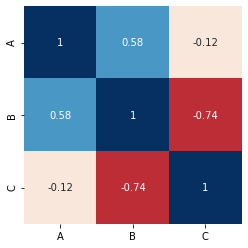

In [15]:
sns.heatmap(cosine_distance(normalised_utility_matrix), **{**DEFAULT_HEATMAP_KWARGS, "vmin":-1})

**Exercise 9.3.2** : In this exercise, we cluster items in the matrix of Fig. 9.8.
Do the following steps.
- (a) Cluster the eight items hierarchically into four clusters. The following
method should be used to cluster. 
    - Replace all 3’s, 4’s, and 5’s by 1 and replace 1’s, 2’s, and blanks by 0. 
    - use the Jaccard distance to measure the distance between the resulting column vectors. 
    - For clusters of more than one element, take the distance between clusters to be the minimum
distance between pairs of elements, one from each cluster.


In [16]:
# p325 suggest to leave a large number of clusters, for example half as many clusters as there are items
k_clusters = int(df.shape[1] / 2)
k_clusters

4

In [17]:
distance_matrix = jaccard_distance(rounding_utility_matrix.T)
distance_matrix

,a,b,c,d,e,f,g,h
a,1.000000,0.666667,0.333333,0.333333,0.666667,0.333333,0.666667,0.333333
b,0.666667,1.000000,0.666667,0.666667,0.333333,0.000000,0.333333,0.000000
c,0.333333,0.666667,1.000000,0.333333,0.666667,0.333333,0.000000,0.333333
d,0.333333,0.666667,0.333333,1.000000,0.000000,0.333333,0.666667,0.333333
e,0.666667,0.333333,0.666667,0.000000,1.000000,0.666667,0.333333,0.666667
f,0.333333,0.000000,0.333333,0.333333,0.666667,1.000000,0.666667,1.000000
g,0.666667,0.333333,0.000000,0.666667,0.333333,0.666667,1.000000,0.666667
h,0.333333,0.000000,0.333333,0.333333,0.666667,1.000000,0.666667,1.000000


In [18]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering
clustering = AgglomerativeClustering(
    n_clusters=k_clusters,
    linkage="single",  # that's what we interpret from the last bullet point in the question
    affinity="precomputed"
)

In [19]:
items = rounding_utility_matrix.T.index
predictions = [f"cluster__{i}" for i in clustering.fit_predict(distance_matrix)]
assignments = {i: c for i, c in zip(items, predictions)}
assignments

{'a': 'cluster__3',
 'b': 'cluster__2',
 'c': 'cluster__1',
 'd': 'cluster__0',
 'e': 'cluster__0',
 'f': 'cluster__2',
 'g': 'cluster__1',
 'h': 'cluster__2'}

In [20]:
item_to_cluster = pd.Series(1, index=pd.MultiIndex.from_tuples(zip(
    predictions, 
    items
))).unstack(fill_value=0)
item_to_cluster = item_to_cluster.div(item_to_cluster.sum(axis="columns"), axis='index')
item_to_cluster

,a,b,c,d,e,f,g,h
cluster__0,0.0,0.000000,0.0,0.5,0.5,0.000000,0.0,0.000000
cluster__1,0.0,0.000000,0.5,0.0,0.0,0.000000,0.5,0.000000
cluster__2,0.0,0.333333,0.0,0.0,0.0,0.333333,0.0,0.333333
cluster__3,1.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000


- (b) Then, construct from the original matrix of Fig. 9.8 a new matrix whose
rows correspond to users, as before, and whose columns correspond to
clusters. Compute the entry for a user and cluster of items by averaging
the nonblank entries for that user and all the items in the cluster.

In [21]:
clustered_utilities = df.stack().rename(index=assignments, level=1).groupby(level=[0, 1]).mean().unstack(fill_value=0)
clustered_utilities

,cluster__0,cluster__1,cluster__2,cluster__3
A,3.0,3.0,3.5,4.0
B,2.0,2.5,2.5,0.0
C,3.0,3.0,3.5,2.0


- (c) Compute the cosine distance between each pair of users, according to your
matrix from Part (b).

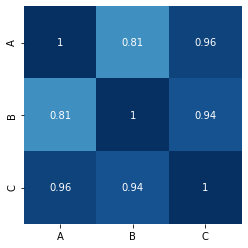

In [22]:
sns.heatmap(cosine_distance(clustered_utilities), **DEFAULT_HEATMAP_KWARGS)

**Remark**: Users B and C are much closer after the clustering than before.